# In Depth, Gaussian Mixture Models 

In [1]:
# KMeans weakness its lack of flexibility in cluster shape and lack of probabilistic cluster assignment

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
from sklearn.datasets import make_blobs

In [84]:
X, y = make_blobs(n_samples=200, centers=4, cluster_std=0.6, random_state=0)

In [85]:
X= X[:, ::-1] # flip the axes

In [86]:
from sklearn.cluster import KMeans

In [87]:
Model = KMeans(n_clusters=4)

In [88]:
centers = Model.fit(X).cluster_centers_

In [89]:
y_model = Model.fit(X).predict(X)

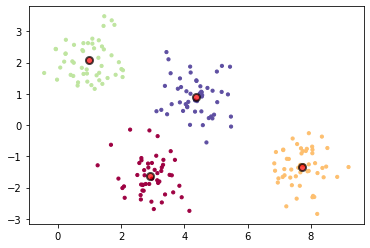

In [90]:
plt.scatter(X[:, 0], X[:,1], c=y_model, s=10, cmap='Spectral')
plt.scatter(centers[:,0], centers[:,1], c='red', s=50, edgecolor='black', linewidth=2, alpha=0.7)

In [91]:
from scipy.spatial.distance import cdist

In [92]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:,0], X[:,1], c=labels, s=10, cmap='viridis', zorder=2)
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)] 
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

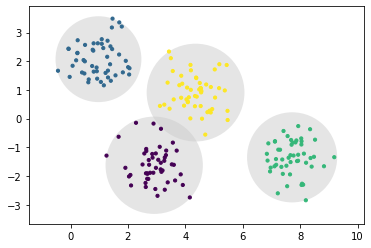

In [93]:
kmeans = KMeans(n_clusters=4, random_state=43)
plot_kmeans(kmeans,X) # these cluster models must be circular for KMeans

# Generalizing E–M: Gaussian Mixture Models

In [94]:
from sklearn import mixture
model1 = mixture.GaussianMixture(n_components=4)

In [95]:
y_ = model1.fit(X).predict(X)

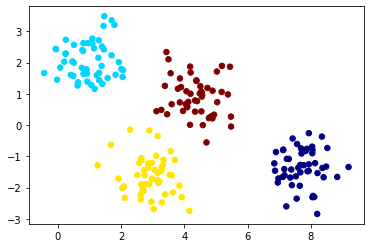

In [96]:
plt.scatter(X[:,0], X[:,1], c=y_, s=30, cmap='jet')

In [97]:
gmm = model1.fit(X)
prob = gmm.predict_proba(X) # a matrix of the probablity of each point at each cluster
print(prob[:5].round(3))

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


In [120]:
prob.shape 

(200, 4)

In [117]:
prob.max(0).shape

(4,)

In [118]:
prob.max(1).shape

(200,)

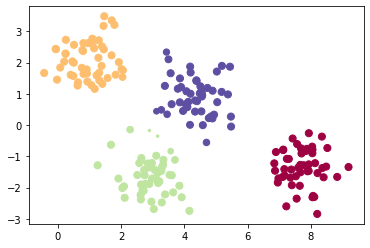

In [109]:
size = 50 * prob.max(1) ** 20
plt.scatter(X[:,0], X[:,1], c=y_, s=size, cmap='Spectral')

In [121]:
# The result of this is that each cluster is associated not with a hard-edged sphere, 
# but with a smooth Gaussian model.

In [123]:
from matplotlib.patches import Ellipse 
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s) 
    else:
        angle = 0 
        width, height = 2 * np.sqrt(covariance)
    # Draw the ellipse 
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [131]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca() 
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    w_factor = 0.2 / gmm.weights_.max() 

    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [132]:
gmm = mixture.GaussianMixture(n_components=4)

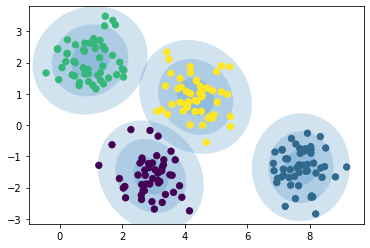

In [133]:
plot_gmm(gmm, X)

In [142]:
gmm2 = mixture.GaussianMixture(n_components=4, covariance_type='full')

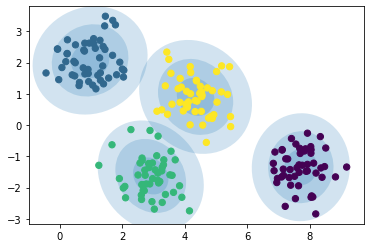

In [143]:
plot_gmm(gmm2, X)

# GMM as Density Estimation

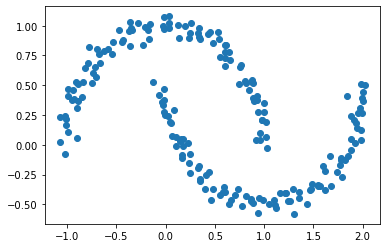

In [144]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

In [146]:
gmm3 = mixture.GaussianMixture(n_components=2, covariance_type='full')

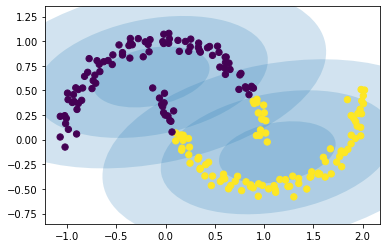

In [148]:
plot_gmm(gmm3, Xmoon)

In [149]:
gmm16 = mixture.GaussianMixture(n_components=16, covariance_type='full')

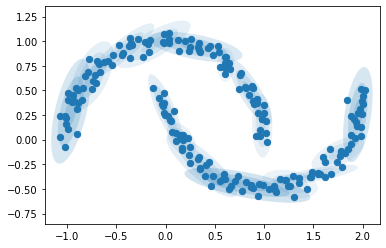

In [151]:
plot_gmm(gmm16, Xmoon, label=False)

In [152]:
# GMM gives us the recipe to generate new random data distributed similarly to our input

In [166]:
Xnew, y = gmm16.sample(400)

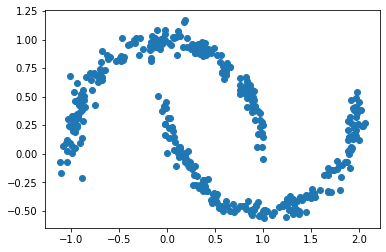

In [167]:
plt.scatter(Xnew[:,0] ,Xnew[:,1])

## How many components?

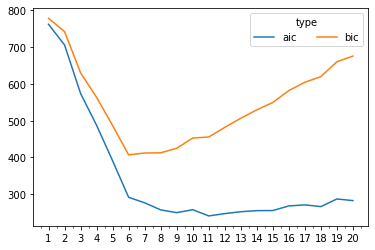

In [186]:
n_components = np.arange(1, 21)
GMM = [mixture.GaussianMixture(n, covariance_type='full').fit(Xmoon)for n in n_components]

plt.plot(n_components, [m.aic(Xmoon) for m in GMM], label='aic')
plt.plot(n_components, [m.bic(Xmoon) for m in GMM], label = 'bic')
plt.legend(title='type', frameon=True, loc='best',ncol=2)
ax = plt.gca()
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

## Example: GMM for Generating New Data

In [187]:
from sklearn.datasets import load_digits

In [188]:
digits = load_digits()

In [190]:
digits.data.shape

(1797, 64)

In [201]:
def plot_digits(data):
    fig, axes = plt.subplots(10,10, figsize=(12,12), subplot_kw=dict(xticks=[], yticks=[]), gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i , ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8,8), cmap='binary')
        for j in ax.spines.values():
            j.set_visible(False)

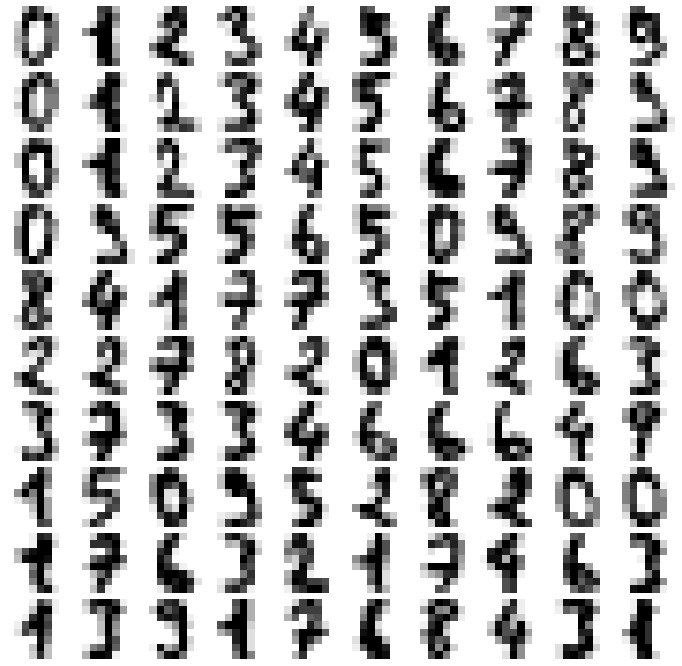

In [202]:
plot_digits(digits.data)

In [203]:
from sklearn.decomposition import PCA

In [205]:
modelB = PCA(0.99)
new_ = modelB.fit_transform(digits.data)

In [206]:
new_.shape

(1797, 41)

In [207]:
n_components = np.arange(50, 210, 10)

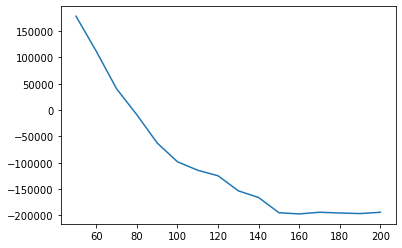

In [234]:
Gmms = [mixture.GaussianMixture(n,covariance_type='full', random_state=0).fit(new_) for n in n_components]
plt.plot(n_components, [m.aic(new_) for m in Gmms])

In [235]:
final = mixture.GaussianMixture(n_components=145, covariance_type='full')

In [238]:
final.fit(new_)
print(final.converged_)

True


In [258]:
data_new = final.sample(100)
data_new[0].shape

(100, 41)

In [260]:
datafinal = modelB.inverse_transform(data_new[0])

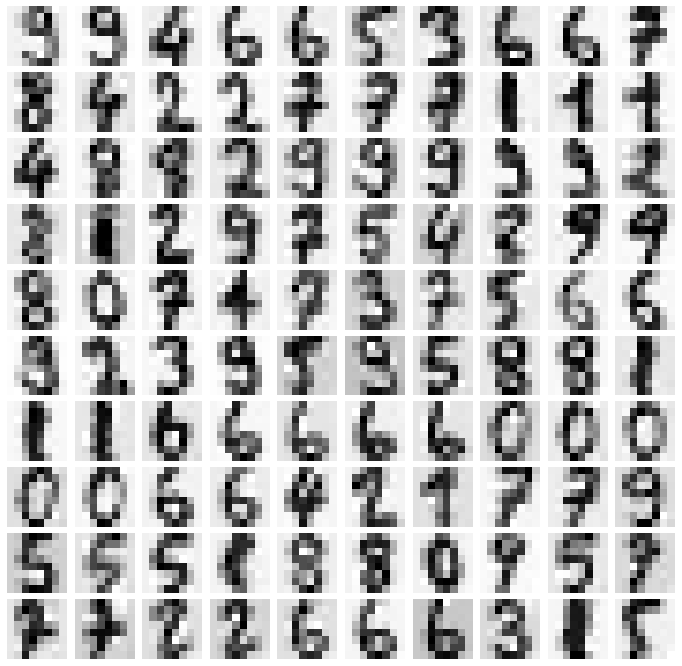

In [262]:
plot_digits(datafinal)